In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from utils import *
from uta import Uta
from norm_layer import NormLayer

PATH = "uta.pt2"

# Data load

In [3]:
# Load data, split into train and test sets and create dataloaders
path = "data/car evaluation.csv"
data = pd.read_csv(path, header=None)
data_1 = data[data.iloc[:, 6] == 1]
data_1 = data_1.sample(n=400, random_state=1234)
data_2 = data[data.iloc[:, 6] == 2]

data_all = pd.concat([data_1, data_2], axis=0)

# mix the rows
data_all = data_all.sample(frac=1, random_state=1234).reset_index(drop=True)


print(data_all.head(5))
print(sum(data_all[6]==1))
print(sum(data_all[6]==2))



target_map = {0: 0, 1: 0, 2: 1, 3: 1, 4: 1}
num_criteria = 6
data_input = data_all.iloc[:, :num_criteria]
data_target = data_all[num_criteria].apply(lambda x: target_map[x])

data_input = data_input.values.reshape(-1, 1, num_criteria)

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

          0         1         2    3    4    5    6
0  0.666667  0.333333  0.666667  1.0  0.0  1.0  2.0
1  0.666667  0.333333  0.000000  0.5  1.0  1.0  2.0
2  0.666667  0.666667  1.000000  0.0  0.0  0.0  1.0
3  1.000000  0.666667  1.000000  0.0  0.0  0.5  1.0
4  0.666667  0.333333  0.666667  1.0  1.0  0.5  2.0
400
384


# Model creation and training

In [4]:
# Create model and train
uta = Uta(num_criteria, 30)
model = NormLayer(uta, num_criteria)
(
    best_acc,
    best_auc,
    stats_train,
    stats_test,
) = Train(model, train_dataloader, test_dataloader, PATH,epoch_nr=300,lr =0.0001,slope_decrease=True)

100%|██████████| 300/300 [00:03<00:00, 87.79it/s]


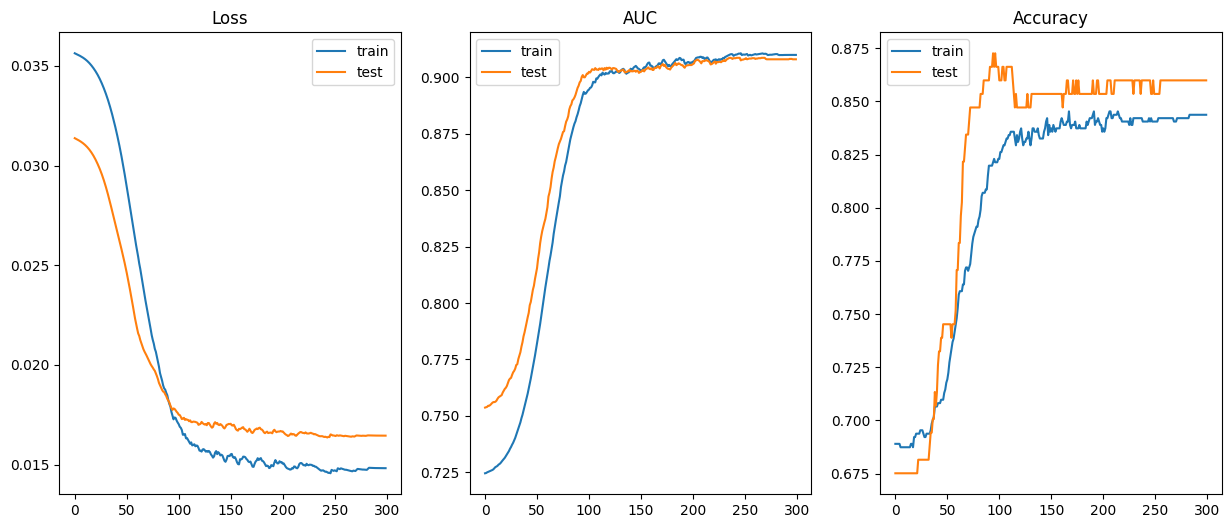

In [5]:
# Plot results
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(131)
ax.plot(stats_train.losses,label='train')
ax.plot(stats_test.losses,label='test')
ax.set_title('Loss')
ax.legend()

ax = fig.add_subplot(1,3,2)
ax.plot(stats_train.auc_scores,label='train')
ax.plot(stats_test.auc_scores,label='test')
ax.set_title('AUC')
ax.legend()

ax = fig.add_subplot(1,3,3)
ax.plot(stats_train.acc_scores,label='train')
ax.plot(stats_test.acc_scores,label='test')
ax.set_title('Accuracy')
ax.legend()

# Ploting marginal value functions of best model

In [6]:
# Load model from checkpoint
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [7]:


hook = Hook(model.method_instance.monotonic_layer, append_output)
xs = []
with torch.no_grad():
    for i in range(201):
        val = i / 200.0
        x = get_simple_input(val,num_criteria)
        xs.append(val)
        model(x)

outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())
# We take every third value becouse the rest are from the normalization layer: velues for 0 and 1
outs = outs[::3] - outs[::3][0]
# Normalize the outputs to get proper weights of the criteria
outs = outs / outs[-1].sum()

/tmp/ipykernel_2194/4087062400.py:10: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  outs = np.array(torch.stack(hook.stats)[:, 0].detach().cpu())


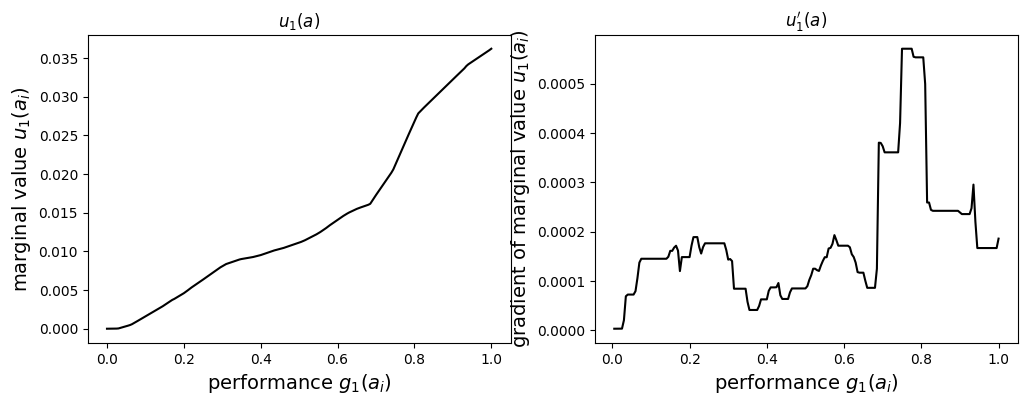

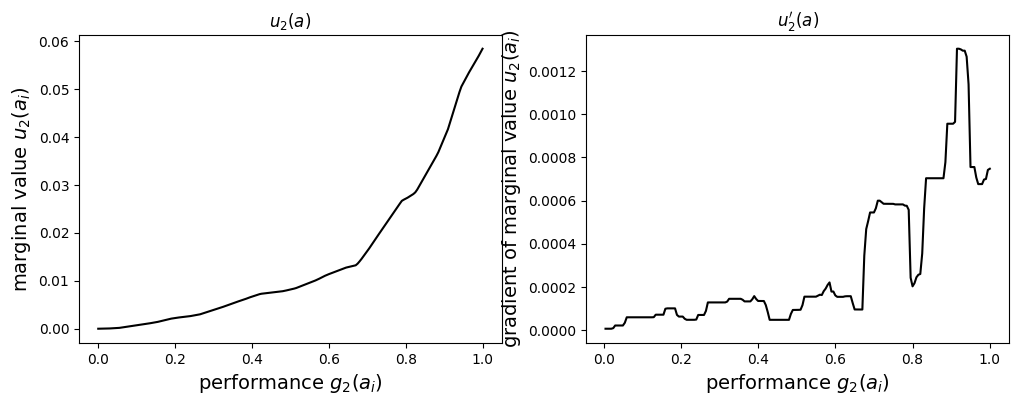

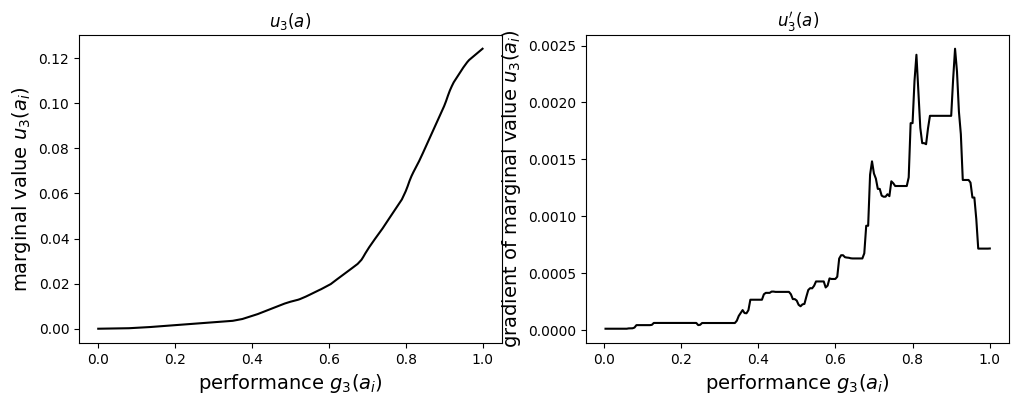

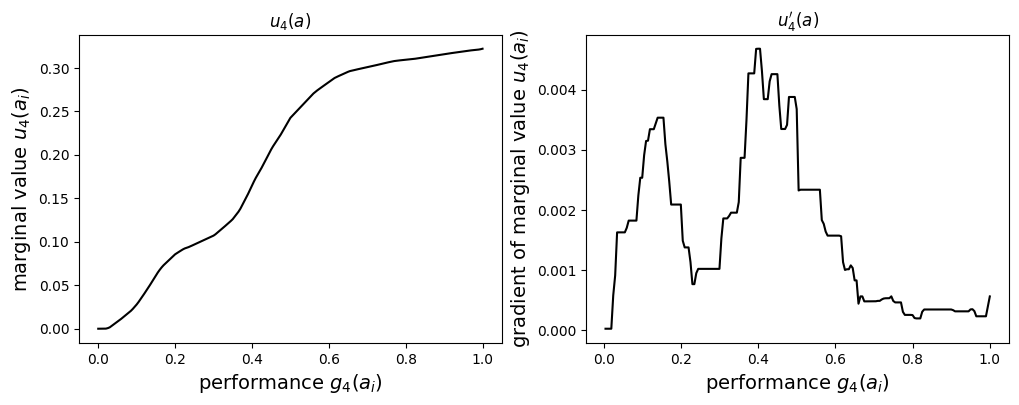

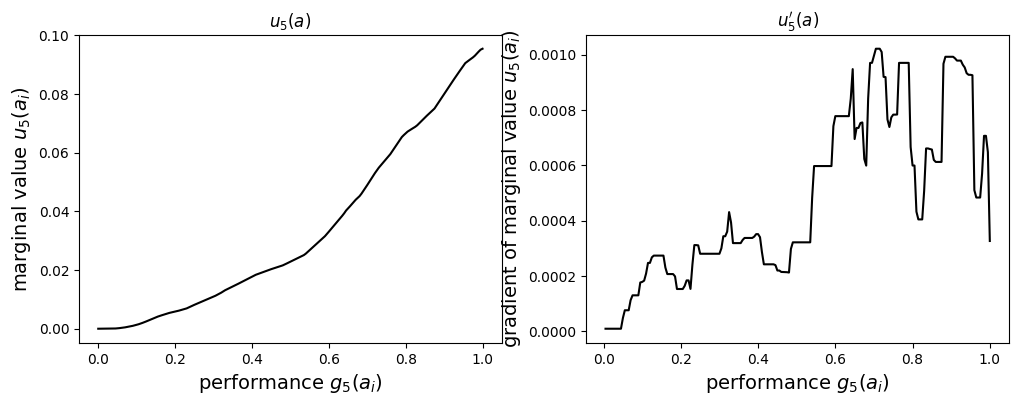

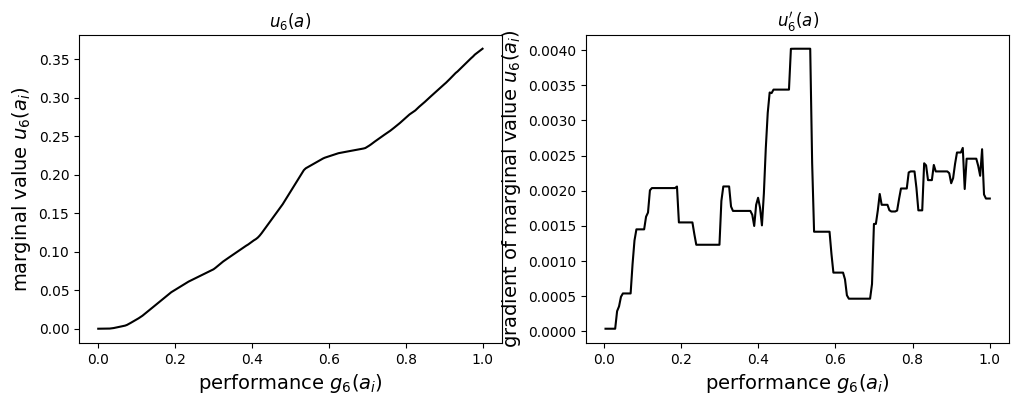

In [8]:
for i in range(num_criteria):
    criterion_number = i + 1
    fig = plt.figure(figsize=(12,4))  
    ax = fig.add_subplot(121)
    ax.set_title(f'$u_{criterion_number}(a)$')
    ax.plot(xs, outs[:, i], color="black")
    ax.set_ylabel(f"marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f"$u_{criterion_number}'(a)$")
    ax.plot(xs[1:], outs[1:, i]-outs[:-1, i], color="black")
    ax.set_ylabel(f"gradient of marginal value $u_{criterion_number}(a_i)$", fontsize=14)
    ax.set_xlabel(f"performance $g_{criterion_number}(a_i)$", fontsize=14)
    plt.show()

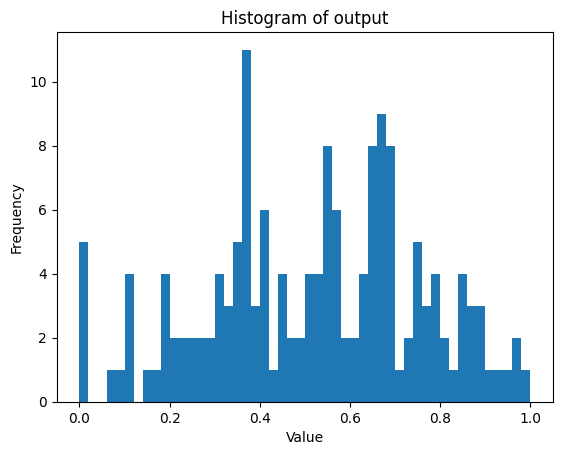

F1 score: 0.8659


In [9]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler

def f1_score_func(y_true, y_pred):
    return f1_score(y_true, y_pred, average="binary")


model.eval()
with torch.no_grad():
    for x, y in test_dataloader:
        output = model(x)
        # reshape
        arr = output.numpy().reshape(-1, 1)
        scaler = MinMaxScaler()
        output = scaler.fit_transform(arr)
        # display histogram
        plt.hist(output, bins=50)
        plt.title("Histogram of output")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.show()
        y_pred = (output > 0.5)
        y_true = y.numpy()
    
    
        print(f"F1 score: {f1_score_func(y_true, y_pred):.4f}")


In [10]:
print(len(y_test))

157


In [11]:
print(sum(y_test == 1))
print(sum(y_test == 0))


75
82


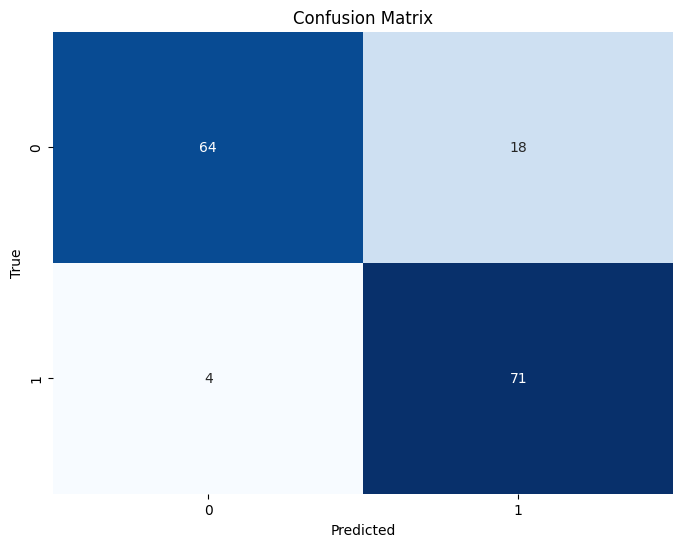

In [12]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
# plot confusion matrix
plot_confusion_matrix(y_true, y_pred)


In [13]:
def test_model(model, test_dataset):
    data_test = test_dataset.reshape(-1, num_criteria)
    data_test_target = np.array([data_target[5], data_target[12], data_target[35]])
    data_test_target = data_test_target.reshape(-1, 1)

    data_set = CreateDataLoader(data_test, data_test_target)

    model.eval()
    with torch.no_grad():
        for x, y in data_set:
            print(x.shape)
            output = model(x)
            # reshape
            y_pred_alt = (output > 0.0)
    return y_pred_alt

In [14]:
alternative_1_pred = y_pred[5]
alternative_2_pred = y_pred[12]
alternative_3_pred = y_pred[35]

alternative_1 = data_input[5].copy()
alternative_2 = data_input[12].copy()
alternative_3 = data_input[35].copy()

print("Alternative 1 prediction: ", alternative_1_pred)
print("Alternative 1: ", alternative_1)
print("Alternative 2 prediction: ", alternative_2_pred)
print("Alternative 2: ", alternative_2)
print("Alternative 3 prediction: ", alternative_3_pred) 
print("Alternative 3: ", alternative_3)

Alternative 1 prediction:  [False]
Alternative 1:  [[1.       0.       0.333333 0.5      0.5      0.5     ]]
Alternative 2 prediction:  [ True]
Alternative 2:  [[0.666667 0.333333 1.       0.5      0.5      1.      ]]
Alternative 3 prediction:  [False]
Alternative 3:  [[0.333333 0.333333 0.333333 0.       0.5      0.      ]]


In [15]:
data_test = np.concatenate((alternative_1, alternative_2, alternative_3), axis=0)
y_pred_alt = test_model(model, data_test)

print(y_pred_alt)


torch.Size([3, 6])
tensor([False,  True, False])


In [16]:
print(alternative_1)
data_test = np.concatenate((alternative_1, alternative_2, alternative_3), axis=0)
y_pred_alt = test_model(model, data_test)

print(y_pred_alt)

alternative_1[0][3] += 0.3
print(alternative_1)

data_test = np.concatenate((alternative_1, alternative_2, alternative_3), axis=0)
y_pred_alt = test_model(model, data_test)

print(y_pred_alt)

[[1.       0.       0.333333 0.5      0.5      0.5     ]]
torch.Size([3, 6])
tensor([False,  True, False])
[[1.       0.       0.333333 0.8      0.5      0.5     ]]
torch.Size([3, 6])
tensor([ True,  True, False])


In [21]:
def predict(alternatives):
    """
    Predict probabilities for a batch of alternatives.
    Args:
        alternatives (numpy array): Input data with shape (n_samples, n_features).
    Returns:
        numpy array: Predicted probabilities with shape (n_samples, n_classes).
    """
    # Convert alternatives to a PyTorch tensor
    alternatives = torch.tensor(alternatives, dtype=torch.float32)


    # Set the model to evaluation mode
    model.eval()
    with torch.no_grad():
        # Get the model's output (logits)
        output = model(alternatives)

        output = output.reshape(output.shape[0],1)

        # Convert logits to probabilities using sigmoid
        probabilities = torch.sigmoid(output).numpy()
        

    # Return probabilities for both classes (0 and 1)
    return np.hstack([1 - probabilities, probabilities])

In [26]:
import lime
import lime.lime_tabular
import numpy as np
import torch

feature_names = [
    "buying_price",
    "price_of_maintenance",
    "doors",
    "persons",
    "lug_boot",
    "safety"
]
class_names = ["unacc", "acc"]


# Reshape X_test for LimeTabularExplainer
print(X_test.shape)
data_test = X_test.reshape(X_test.shape[0], X_test.shape[2])
print(data_test.shape)

# Test the predict function
sample_data = data_test[:5]  # Take 5 samples from the test data
predicted_probs = predict(sample_data)

print("Predicted probabilities shape:", predicted_probs.shape)
print("Predicted probabilities:", predicted_probs)


# Initialize LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    class_names=class_names,
    feature_names=feature_names,
    training_data=data_test
)

# Explain an instance
exp = explainer.explain_instance(
    data_row=data_test[1],  # Single instance to explain
    predict_fn=predict,     # Updated predict function
    num_features=6
)

# # Display explanation
print(exp.as_list())

(157, 1, 6)
(157, 6)
Predicted probabilities shape: (5, 2)
Predicted probabilities: [[0.39626187 0.6037381 ]
 [0.5054444  0.49455556]
 [0.599026   0.40097398]
 [0.5094626  0.49053743]
 [0.5191188  0.48088124]]
[('0.00 < doors <= 0.67', -0.013544055087260087), ('0.00 < persons <= 0.50', 0.012586597667083291), ('price_of_maintenance <= 0.33', -0.009256343797552994), ('0.00 < lug_boot <= 0.50', -0.0052296150729952634), ('0.00 < safety <= 0.50', -0.0037648353767120854), ('0.33 < buying_price <= 0.67', 0.0011631797319668776)]
